In [20]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):       
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

In [33]:
class gameEnv():
    def __init__(self, size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        a = self.reset()
        plt.imshow(a, interpolation="nearest")
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        
        goal = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal)
        
        hole = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole)
        
        goal2 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal2)
        
        hole2 = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole2)
        
        goal3 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal3)
        
        goal4 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal4)
        
        state = self.renderEnv()
        self.state = state
        
        return state
    
    def moveChar(self,direction):
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY - 2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX - 2:
            hero.x += 1
            
    def newPosition(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        
        for objectA in self.objects:
            if(objectA.x, objectA.y) not in currentPositions:
                currentPositions.append((objectA.x, objectA.y))
                
        for pos in currentPositions:
            points.remove(pos)
        
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]
    
    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                    
                return other.reward,False
        return 0.0,False
    
    def renderEnv(self):
        a = np.ones([self.sizeY+2,self.sizeX+2,3])
        a[1:-1,1:-1,:] = 0
        hero = None
        
        for item in self.objects:
            a[item.y+1:item.y+item.size+1, item.x+1:item.x+item.size+1, item.channel] = item.intensity
            
        b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp='nearest')
        c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp='nearest')
        d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp='nearest')
        a = np.stack([b,c,d],axis=2)
        
        return a
    
    def step(self,action):
        self.moveChar(action)
        reward,done = self.checkGoal()
        state = self.renderEnv()
        return state,reward,done

C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


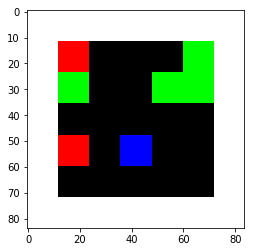

In [34]:
env = gameEnv(size=5)

In [35]:
class Qnetwork():
    def __init__(self,h_size):
        self.scalerInput = tf.placeholder(tf.float32, shape=[None,21168])
        self.imageIn = tf.reshape(self.scalerInput, shape=[-1,84,84,3])
        
        self.conv1 = tf.contrib.layers.convolution2d(inputs=self.imageIn, num_outputs=32,
                                                     kernel_size=[8,8], stride=[4,4], padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(inputs=self.conv1, num_outputs=64,
                                                     kernel_size=[4,4], stride=[2,2], padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(inputs=self.conv2, num_outputs=64,
                                                     kernel_size=[3,3], stride=[1,1], padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(inputs=self.conv3, num_outputs=512,
                                                     kernel_size=[7,7], stride=[1,1], padding='VALID', biases_initializer=None)
        
        #將conv4拆成DQN的Advantage Function和Value Function
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3) #第二個參數是要拆幾段，第三個是要拆第幾個維度
        self.streamA = tf.contrib.layers.flatten(self.streamAC) 
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        
        #創建Fully connect
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))   #Action數量
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        #Q值
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        self.targetQ = tf.placeholder(tf.float32,shape=[None])
        self.actions = tf.placeholder(tf.int32,shape=[None])
        self.action_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.action_onehot), reduction_indices=1)
        
        #loss計算targetQ跟Q的均方誤差
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [36]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer)) - self.buffer_size] = []
            
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size,5])

In [37]:
def processState(states):
    return np.reshape(states,[21168])
    
#更新Targer DQN
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
        
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx + total_vars//2].assign((var.value() * tau) + \
                                                                ((1 - tau) * tfVars[idx+total_vars//2].value())))
    return op_holder
    
def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

In [39]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000#How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)
init = tf.global_variables_initializer()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

e = startE
stepDrop = (startE - endE)/anneling_steps

rList = []
total_steps = 0

saver = tf.train.Saver()
if not os.path.exists(path):
    os.makedirs(path)
    
with tf.Session() as sess:
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    sess.run(init)
    updateTarget(targetOps, sess)
    
    for i in range(num_episodes+1):
        episodeBuffer = experience_buffer()
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        while j < max_epLength:
            j+=1
            
            #總步數小於pre_train_steps強制使用隨機Action
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalerInput:[s]})[0]
            
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                    
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size)
                    A = sess.run(mainQN.predict, feed_dict={mainQN.scalerInput:np.vstack(trainBatch[:,3])})
                    
                    Q = sess.run(targetQN.Qout, feed_dict={targetQN.scalerInput:np.vstack(trainBatch[:,3])})
                    
                    doubleQ = Q[range(batch_size), A]
                    targetQ = trainBatch[:,2] + y*doubleQ
                    _ = sess.run(mainQN.updateModel, feed_dict={mainQN.scalerInput:np.vstack(trainBatch[:,0]),
                                                                mainQN.targetQ:targetQ,
                                                                mainQN.actions:trainBatch[:,1]})
                    updateTarget(targetOps,sess)
                    
            rAll += r
            s = s1
                
            if d == True:
                break
                    
        myBuffer.add(episodeBuffer.buffer)
        rList.append(rAll)
                
        if i>0 and i%25 == 0:
            print('episode',i,' average reward of last 25 episode', np.mean(rList[-25:]))
                    
        if i>0 and i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print('Saved Model')
    saver.save(sess,path+'/model-'+str(i)+'.cptk')

C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


episode 25  average reward of last 25 episode 2.08
episode 50  average reward of last 25 episode 2.16
episode 75  average reward of last 25 episode 1.52
episode 100  average reward of last 25 episode 3.04
episode 125  average reward of last 25 episode 2.8
episode 150  average reward of last 25 episode 2.04
episode 175  average reward of last 25 episode 2.28
episode 200  average reward of last 25 episode 1.8
episode 225  average reward of last 25 episode 1.08
episode 250  average reward of last 25 episode 2.52
episode 275  average reward of last 25 episode 1.92
episode 300  average reward of last 25 episode 1.6
episode 325  average reward of last 25 episode 1.24
episode 350  average reward of last 25 episode 0.96
episode 375  average reward of last 25 episode 0.76
episode 400  average reward of last 25 episode 0.72
episode 425  average reward of last 25 episode 0.08
episode 450  average reward of last 25 episode 0.24
episode 475  average reward of last 25 episode 0.52
episode 500  avera

episode 3925  average reward of last 25 episode 0.76
episode 3950  average reward of last 25 episode 0.56
episode 3975  average reward of last 25 episode 0.92
episode 4000  average reward of last 25 episode 0.6
Saved Model
episode 4025  average reward of last 25 episode 0.64
episode 4050  average reward of last 25 episode 0.12
episode 4075  average reward of last 25 episode 0.44
episode 4100  average reward of last 25 episode 0.96
episode 4125  average reward of last 25 episode 0.6
episode 4150  average reward of last 25 episode 0.52
episode 4175  average reward of last 25 episode 0.68
episode 4200  average reward of last 25 episode 0.48
episode 4225  average reward of last 25 episode 0.56
episode 4250  average reward of last 25 episode 0.8
episode 4275  average reward of last 25 episode 0.4
episode 4300  average reward of last 25 episode 0.76
episode 4325  average reward of last 25 episode 0.32
episode 4350  average reward of last 25 episode 0.4
episode 4375  average reward of last 25

episode 7800  average reward of last 25 episode 0.52
episode 7825  average reward of last 25 episode 0.4
episode 7850  average reward of last 25 episode 0.4
episode 7875  average reward of last 25 episode 0.44
episode 7900  average reward of last 25 episode 0.76
episode 7925  average reward of last 25 episode 0.64
episode 7950  average reward of last 25 episode 0.6
episode 7975  average reward of last 25 episode 0.52
episode 8000  average reward of last 25 episode 0.4
Saved Model
episode 8025  average reward of last 25 episode 0.6
episode 8050  average reward of last 25 episode 0.28
episode 8075  average reward of last 25 episode 0.44
episode 8100  average reward of last 25 episode 0.32
episode 8125  average reward of last 25 episode 0.6
episode 8150  average reward of last 25 episode 0.2
episode 8175  average reward of last 25 episode 0.68
episode 8200  average reward of last 25 episode 0.68
episode 8225  average reward of last 25 episode 0.44
episode 8250  average reward of last 25 e

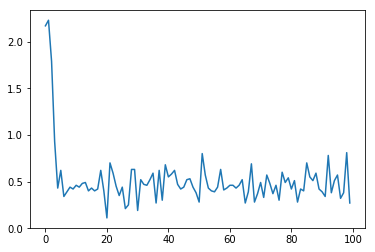

In [40]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

In [42]:
rList[-2:]

[1.0, 2.0]